In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import json
import time

In [2]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

# arrays to normalization
normalize_mean = np.array([0.485, 0.456, 0.406])
normalize_std = np.array([0.229, 0.224, 0.225])

# Define your transforms for the training and validation sets
data_transforms = {}

# transforms to train data set
data_transforms['train'] = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        ]),
    transforms.Resize(300),
    transforms.RandomSizedCrop(224),
    transforms.Resize(100),
    transforms.ToTensor(),
    transforms.Normalize(
        normalize_mean,
        normalize_std)
    ])

# transforms to valid data set
data_transforms['valid'] = transforms.Compose([
    transforms.RandomChoice([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(60),
    ]),
    transforms.Resize(300),
    transforms.CenterCrop(224),
    transforms.Resize(100),
    transforms.ToTensor(),
    transforms.Normalize(
        normalize_mean,
        normalize_std)
    ])

# transforms to test data set
data_transforms['test'] = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomRotation(45),
        transforms.RandomRotation(75),
        transforms.RandomRotation(90),
        ]),
    transforms.Resize(300),
    transforms.CenterCrop(224),
    transforms.Resize(100),
    transforms.ToTensor(),
    transforms.Normalize(
        normalize_mean,
        normalize_std)
    ])

# Load the datasets with ImageFolder
image_datasets = {}
image_datasets['train_data'] = datasets.ImageFolder(data_dir + '/train', transform=data_transforms['train'])
image_datasets['valid_data'] = datasets.ImageFolder(data_dir + '/valid', transform=data_transforms['valid'])
image_datasets['test_data'] = datasets.ImageFolder(data_dir + '/valid', transform=data_transforms['test'])

# Using the image datasets and the transforms, define the dataloaders
dataloaders = {}
dataloaders['train_data'] = torch.utils.data.DataLoader(image_datasets['train_data'], batch_size=64, shuffle=True)
dataloaders['valid_data'] = torch.utils.data.DataLoader(image_datasets['valid_data'], batch_size=64, shuffle=False)
dataloaders['test_data'] = torch.utils.data.DataLoader(image_datasets['test_data'], batch_size=64, shuffle=True)
print(f"Train data: {len(dataloaders['train_data'].dataset)} images / {len(dataloaders['train_data'])} batches")
print(f"Valid data: {len(dataloaders['valid_data'].dataset)} images / {len(dataloaders['valid_data'])} batches")
print(f"Test  data: {len(dataloaders['test_data'].dataset)} images / {len(dataloaders['test_data'])} batches") 

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:693: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +


Train data: 6552 images / 103 batches
Valid data: 818 images / 13 batches
Test  data: 818 images / 13 batches


In [3]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

class_to_idx = image_datasets['train_data'].class_to_idx

cat_label_to_name = {}
for cat, label in class_to_idx.items():
    cat_label_to_name[label] = cat_to_name.get(cat)

print(cat_label_to_name)

{0: 'pink primrose', 1: 'globe thistle', 2: 'blanket flower', 3: 'trumpet creeper', 4: 'blackberry lily', 5: 'snapdragon', 6: "colt's foot", 7: 'king protea', 8: 'spear thistle', 9: 'yellow iris', 10: 'globe-flower', 11: 'purple coneflower', 12: 'peruvian lily', 13: 'balloon flower', 14: 'hard-leaved pocket orchid', 15: 'giant white arum lily', 16: 'fire lily', 17: 'pincushion flower', 18: 'fritillary', 19: 'red ginger', 20: 'grape hyacinth', 21: 'corn poppy', 22: 'prince of wales feathers', 23: 'stemless gentian', 24: 'artichoke', 25: 'canterbury bells', 26: 'sweet william', 27: 'carnation', 28: 'garden phlox', 29: 'love in the mist', 30: 'mexican aster', 31: 'alpine sea holly', 32: 'ruby-lipped cattleya', 33: 'cape flower', 34: 'great masterwort', 35: 'siam tulip', 36: 'sweet pea', 37: 'lenten rose', 38: 'barbeton daisy', 39: 'daffodil', 40: 'sword lily', 41: 'poinsettia', 42: 'bolero deep blue', 43: 'wallflower', 44: 'marigold', 45: 'buttercup', 46: 'oxeye daisy', 47: 'english marig

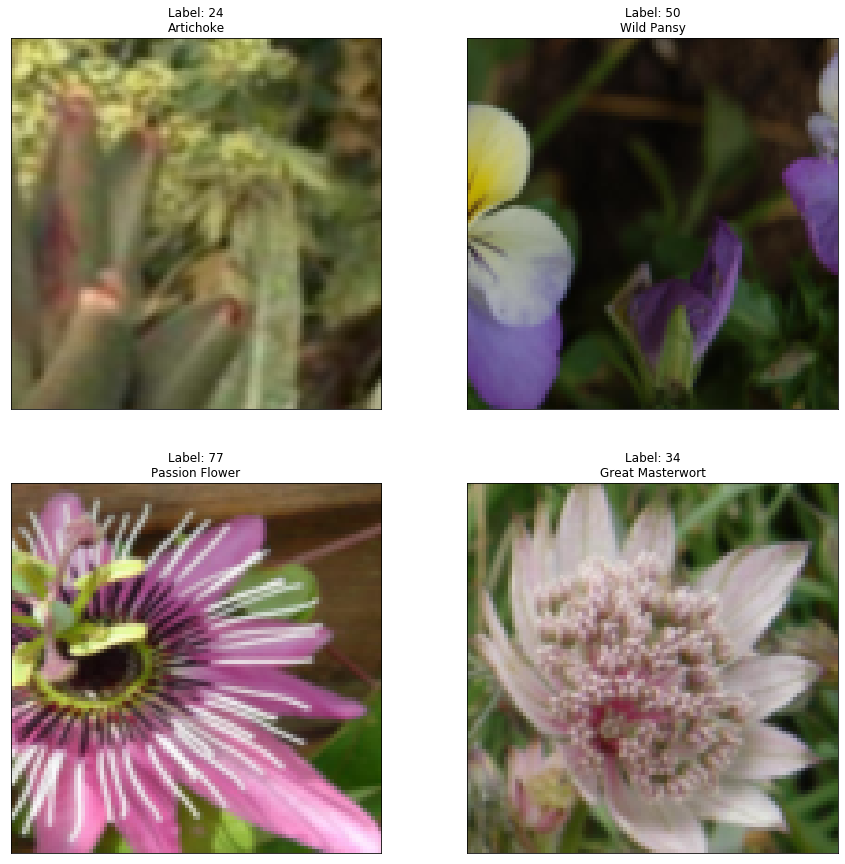

In [4]:
# functions to show an image
def imgview(img, title, ax):
    # un-normalize
    for i in range(img.shape[0]):
        img[i] = img[i] * normalize_std[i] + normalize_mean[i]
    # convert from Tensor image
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(title)

# obtain one batch of training images
dataiter = iter(dataloaders['train_data'])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# show some test images
fig = plt.figure(figsize=(15, 15))
fig_rows, fig_cols = 2,2
for index in np.arange(fig_rows*fig_cols):
    img = images[index]
    label = labels[index].item()
    title = f'Label: {label}\n{cat_label_to_name[label].title()}'
    ax = fig.add_subplot(fig_rows, fig_cols, index+1, xticks=[], yticks=[])
    imgview(img, title, ax)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, padding = 3)
        self.conv2 = nn.Conv2d(64, 128, 5, padding = 3)
        self.conv3 = nn.Conv2d(128, 256, 3, padding = 1)
        self.conv4 = nn.Conv2d(256, 512, 3, padding = 1)
        self.conv5 = nn.Conv2d(512, 512, 3, padding = 2)
        self.pool = nn.MaxPool2d(3, 2)
        self.fc1 = nn.Linear(512 * 6 * 6, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 102)
        self.drop = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 512 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x

net = Net()

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
net.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=102, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)

In [8]:
trainloss = []
trainacc = []
testloss = []
testacc = []
since = time.time()
for epoch in range(800):  # loop over the dataset multiple times
    print('Epoch {}/{}'.format(epoch+1, 800))
    print('-' * 10)

    for phase in ['train','test']:
        if phase == 'train':
            dataloader = dataloaders['train_data']
        elif phase == 'test':
            dataloader = dataloaders['test_data']
                
        running_corrects = 0
        running_loss = 0
    
        for data in dataloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # acc loss
            running_loss  += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()
            
        if phase=="train":
            epoch_loss = running_loss / len(dataloaders['train_data'])
            epoch_acc = running_corrects / len(image_datasets['train_data'])
            trainloss.append(epoch_loss)
            trainacc.append(epoch_acc)

        elif phase == 'test':
            epoch_loss = running_loss / len(dataloaders['test_data'])
            epoch_acc = running_corrects / len(image_datasets['test_data'])
            testloss.append(epoch_loss)
            testacc.append(epoch_acc)
        
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Finished Training')

Epoch 1/800
----------
train Loss: 4.6224 Acc: 0.0099
test Loss: 4.6188 Acc: 0.0220
Epoch 2/800
----------
train Loss: 4.6172 Acc: 0.0285
test Loss: 4.6129 Acc: 0.0342
Epoch 3/800
----------
train Loss: 4.6113 Acc: 0.0305
test Loss: 4.6078 Acc: 0.0355
Epoch 4/800
----------
train Loss: 4.6030 Acc: 0.0319
test Loss: 4.5931 Acc: 0.0342
Epoch 5/800
----------
train Loss: 4.5782 Acc: 0.0299
test Loss: 4.5476 Acc: 0.0244
Epoch 6/800
----------
train Loss: 4.5364 Acc: 0.0313
test Loss: 4.5184 Acc: 0.0330
Epoch 7/800
----------
train Loss: 4.5295 Acc: 0.0302
test Loss: 4.5044 Acc: 0.0330
Epoch 8/800
----------
train Loss: 4.5173 Acc: 0.0311
test Loss: 4.5009 Acc: 0.0293
Epoch 9/800
----------
train Loss: 4.5116 Acc: 0.0324
test Loss: 4.5011 Acc: 0.0257
Epoch 10/800
----------
train Loss: 4.4936 Acc: 0.0411
test Loss: 4.4634 Acc: 0.0403
Epoch 11/800
----------
train Loss: 4.4043 Acc: 0.0508
test Loss: 4.3041 Acc: 0.0526
Epoch 12/800
----------
train Loss: 4.2655 Acc: 0.0505
test Loss: 4.2054 A

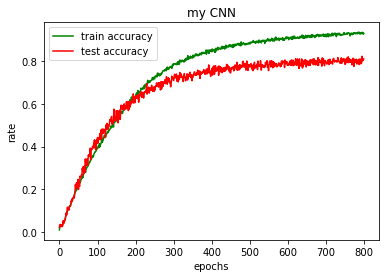

In [9]:
x = [i for i in range(len(trainacc))]

ax = plt.gca()

plt.title('my CNN')
ax.plot(x, trainacc,color='green', label='train accuracy')
ax.plot(x, testacc,color='red', label='test accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('rate')
plt.savefig('cnn acc.png')
plt.show()
plt.close()

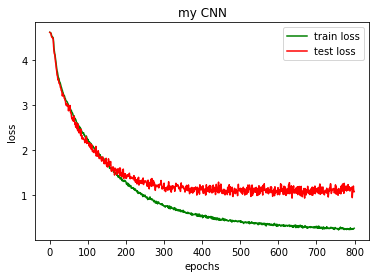

In [17]:
y = [i for i in range(len(trainloss))]

ay = plt.gca()
plt.title('my CNN')
ay.plot(y, trainloss, color='green', label='train loss')
ay.plot(y, testloss, color='red', label='test loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('cnn loss.png')
plt.show()
plt.close()

In [19]:
import pandas as pd
data_loss = pd.DataFrame({'trainloss': trainloss, 'testloss': testloss})
data_acc = pd.DataFrame({'trainacc': trainacc, 'testacc': testacc})
data_loss.to_csv('cnn loss.csv')
data_acc.to_csv("cnn acc.csv")

In [20]:
PATH = './flower_cnn.pth'
torch.save(net.state_dict(), PATH)

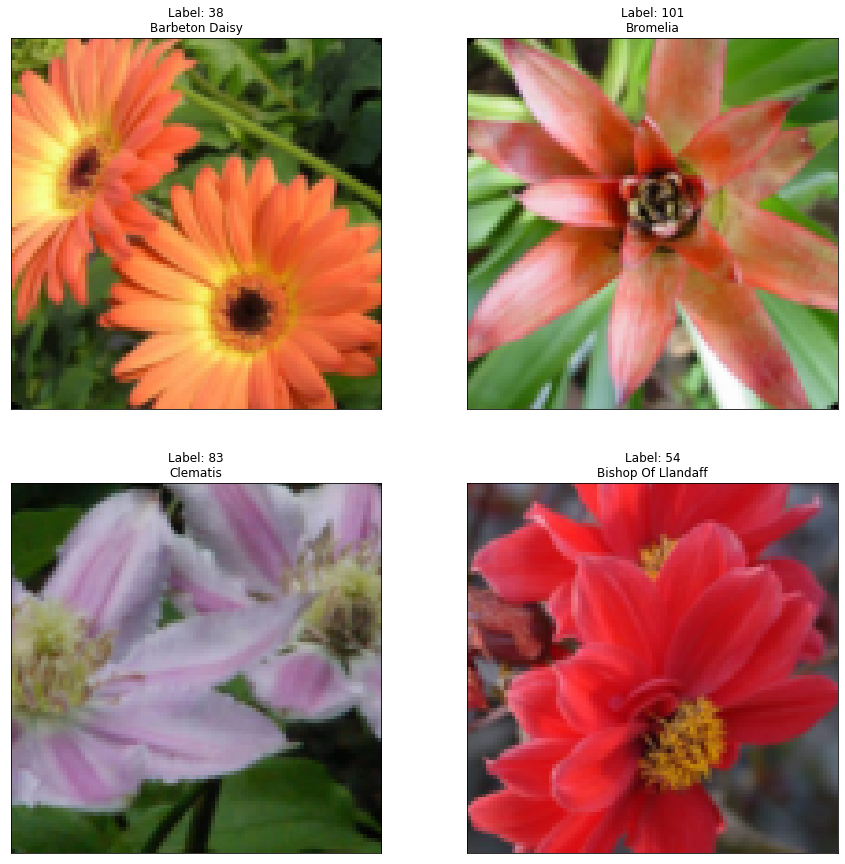

In [21]:
# obtain one batch of training images
dataiter = iter(dataloaders['test_data'])
images, labels = dataiter.next()
npimg = images.numpy() # convert images to numpy for display

# show some test images
fig = plt.figure(figsize=(15, 15))
fig_rows, fig_cols = 2,2
for index in np.arange(fig_rows*fig_cols):
    img = npimg[index]
    label = labels[index].item()
    title = f'Label: {label}\n{cat_label_to_name[label].title()}'
    ax = fig.add_subplot(fig_rows, fig_cols, index+1, xticks=[], yticks=[])
    imgview(img, title, ax)

In [22]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [23]:
outputs = net(images)

In [24]:
_, predicted = torch.max(outputs, 1)
predicted = predicted.numpy()
print('Predicted: ', ', '.join('%5s' % cat_label_to_name[predicted[j]] for j in range(4)))

Predicted:  hippeastrum, hippeastrum,  rose, hippeastrum


In [30]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders['test_data']:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 409 test images: %f %%' % (100 * correct / total))

Accuracy of the network on the 409 test images: 79.951100 %


In [26]:
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))
with torch.no_grad():
    for data in dataloaders['test_data']:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(c)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(102):
    print('Accuracy of %5s : %2d %%' % (
        cat_label_to_name[i], 100 * class_correct[i] / class_total[i]))

Accuracy of pink primrose : 87 %
Accuracy of globe thistle : 75 %
Accuracy of blanket flower : 100 %
Accuracy of trumpet creeper : 60 %
Accuracy of blackberry lily : 100 %
Accuracy of snapdragon : 80 %
Accuracy of colt's foot : 60 %
Accuracy of king protea : 60 %
Accuracy of spear thistle : 100 %
Accuracy of yellow iris : 85 %
Accuracy of globe-flower :  0 %
Accuracy of purple coneflower : 87 %
Accuracy of peruvian lily : 63 %
Accuracy of balloon flower : 75 %
Accuracy of hard-leaved pocket orchid : 83 %
Accuracy of giant white arum lily : 71 %
Accuracy of fire lily : 50 %
Accuracy of pincushion flower : 87 %
Accuracy of fritillary : 91 %
Accuracy of red ginger : 60 %
Accuracy of grape hyacinth : 100 %
Accuracy of corn poppy : 100 %
Accuracy of prince of wales feathers : 100 %
Accuracy of stemless gentian : 100 %
Accuracy of artichoke : 85 %
Accuracy of canterbury bells : 50 %
Accuracy of sweet william : 60 %
Accuracy of carnation : 50 %
Accuracy of garden phlox : 66 %
Accuracy of love

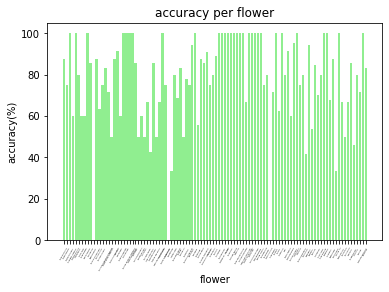

In [27]:
name_list = list(cat_label_to_name.values())
num_list = [100 * class_correct[i] / class_total[i] for i in range(len(class_total))]
plt.bar(name_list, num_list, color='lightgreen')
plt.xlabel('flower')
plt.ylabel('accuracy(%)')
plt.title('accuracy per flower')
plt.xticks(size= 'small',rotation=60,fontsize=2)
plt.savefig('accuracy per flower.png')
plt.show()

In [28]:
apf = {'flower': name_list, 'accuracy': num_list}
floweracc = pd.DataFrame(apf)
floweracc.to_csv('floweracc.csv')

In [29]:
floweracc

,flower,accuracy
0,pink primrose,87.500000
1,globe thistle,75.000000
2,blanket flower,100.000000
3,trumpet creeper,60.000000
4,blackberry lily,100.000000
5,snapdragon,80.000000
6,colt's foot,60.000000
7,king protea,60.000000
8,spear thistle,100.000000
9,yellow iris,85.714286
